<a href="https://colab.research.google.com/github/shrestha94sujan/stocks_analysis/blob/master/stocks_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print('hello world of stocks!')

hello world of stocks!


**Installing yfinance api for importing the financial stuffs.**

In [2]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=1b18ce6fd57b252ca7f10c4253f9540bd156f857e06132e9c7a3b14aa77ea908
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


**Adding import statements.**

In [128]:
import yfinance as yf

# Just get the AAPL stocks, cuz frankly that's all i am interested in, lol
aapl = yf.Ticker('AAPL')

#get historical market data
hist = aapl.history(period='30y')
hist.reset_index(inplace=True)

#if you wish to look at the entire historical data for last 30 years!
hist

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1990-05-11,1.20,1.24,1.18,1.24,53810400,0.00,0.0
1,1990-05-14,1.24,1.24,1.20,1.21,56596400,0.00,0.0
2,1990-05-15,1.20,1.22,1.19,1.21,37346400,0.00,0.0
3,1990-05-16,1.21,1.21,1.19,1.21,21826000,0.00,0.0
4,1990-05-17,1.21,1.22,1.19,1.20,38396400,0.00,0.0
...,...,...,...,...,...,...,...,...
7553,2020-05-05,294.26,300.19,293.67,296.76,36937800,0.00,0.0
7554,2020-05-06,299.65,302.42,298.06,299.82,35583400,0.00,0.0
7555,2020-05-07,302.40,304.35,301.15,302.92,28803800,0.00,0.0
7556,2020-05-08,305.64,310.35,304.29,310.13,33459600,0.82,0.0


**Historical charts that shows opening and closing stock prices.**

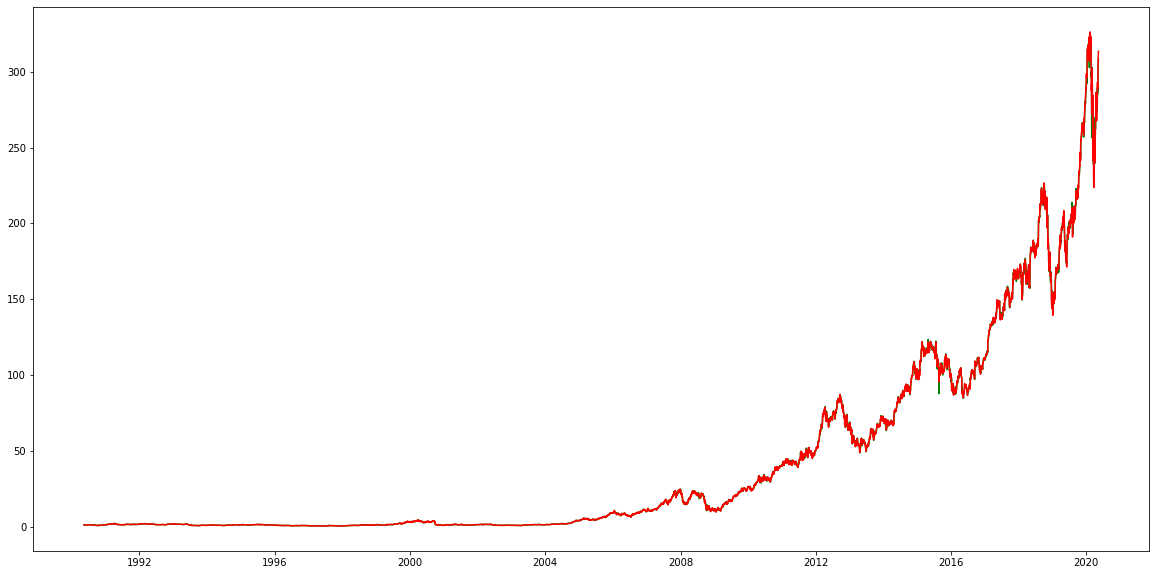

In [77]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from matplotlib.ticker import FixedFormatter, FixedLocator
%matplotlib inline

#Plot Open and Close prices.
plt.figure(figsize=(20, 10))
plt.plot(hist['Open'], color='green')
plt.plot(hist['Close'], color='red')



As we can see, the chart really doesn't help us draw a good understanding of the stock except show an increasing trend! That's where the Data modeling and clustering comes in. 

**Modeling our stock price data to meet requirements.**

<function matplotlib.pyplot.show>

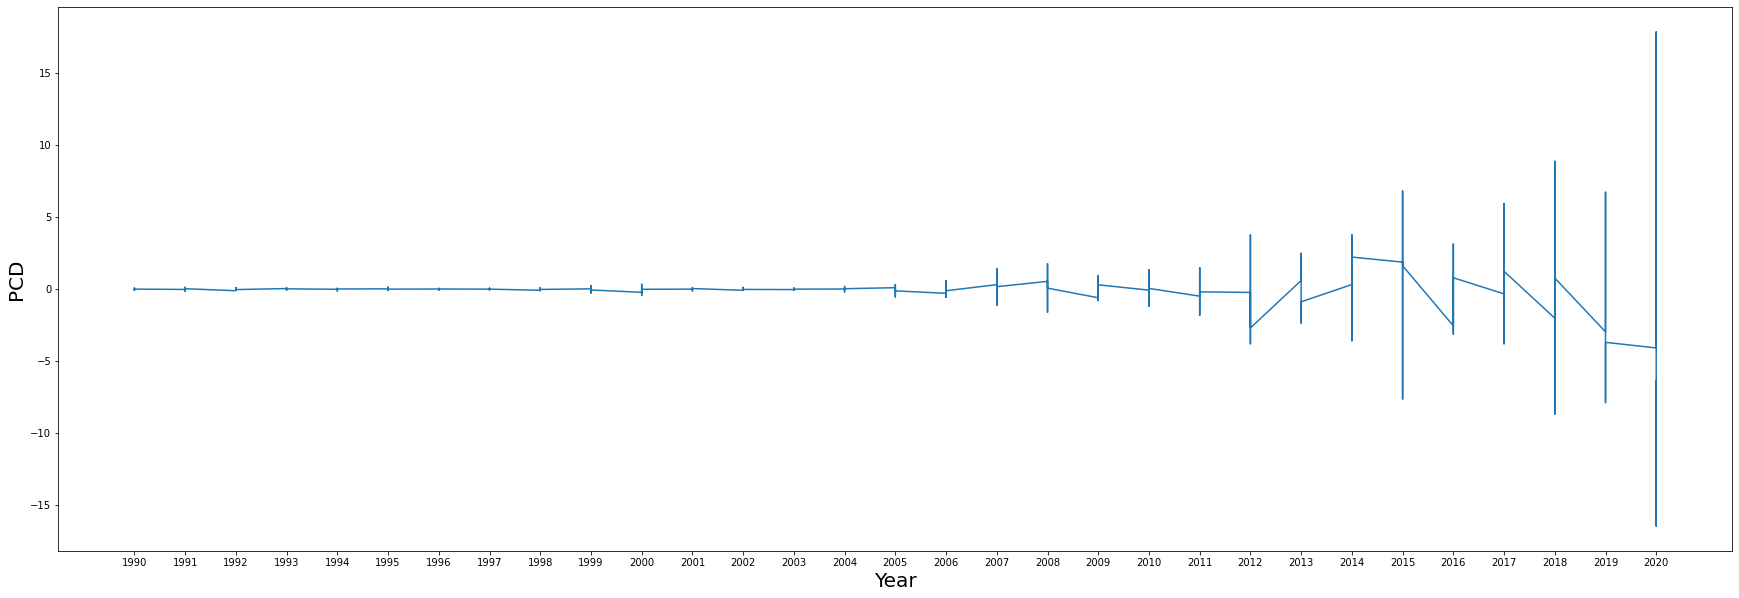

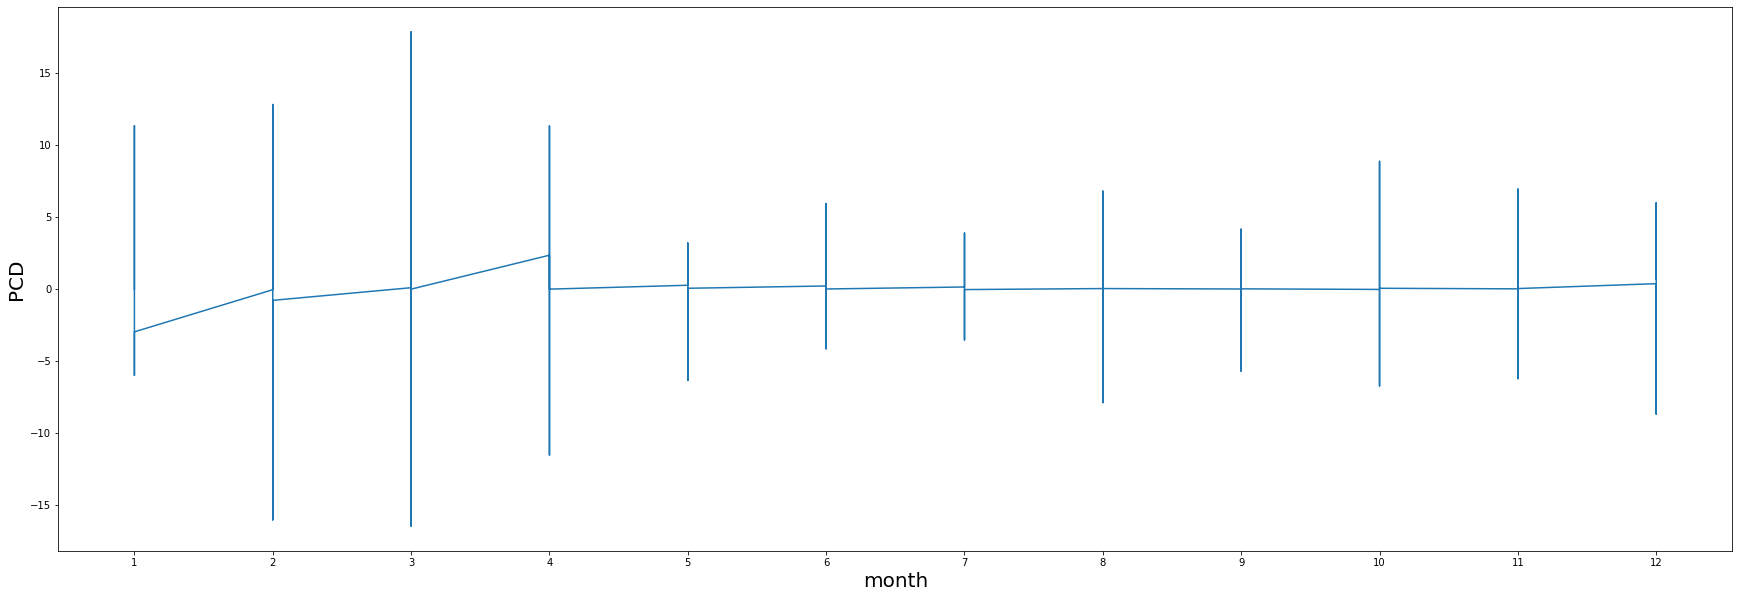

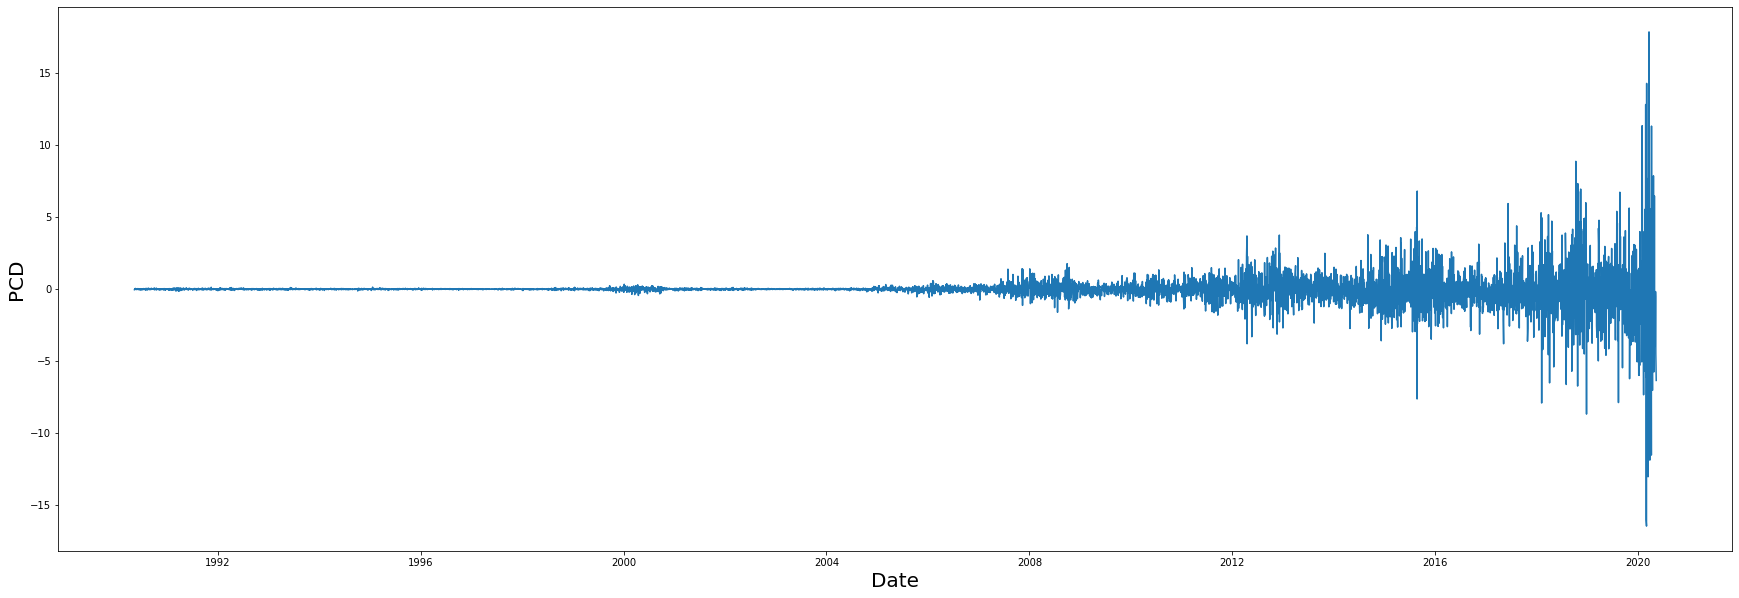

In [178]:
import pandas as pd
import numpy as np


pd.set_option('display.max_rows', None)

#price change per day
pcd = hist['Open'] - hist['Close']

# print(pcd)  #printing out price change per day just becuz.
hist['PCD'] = pcd #Storing vaules in a new 'PCD' column

years = pd.DatetimeIndex(hist['Date']).year #Getting years from the datetime index from the timeseries data
hist['YEAR'] = years

months = pd.DatetimeIndex(hist['Date']).month #Getting months from the datetime index from the timeseries data
hist['MONTH'] = months

#Getting min and max year for x axis
min_year = np.amin(np.asarray(hist['YEAR']))
max_year = np.amax(np.asarray(hist['YEAR']))

#Plotting the PCD against YEAR
plt.figure(figsize=(30, 10))  #Setting the figure size
plt.plot(hist['YEAR'], hist['PCD'])
plt.xlabel('Year', fontsize=20)
plt.xticks(range(min_year, max_year + 1))
plt.ylabel('PCD', fontsize=20)

#Plotting the PCD against MONTH
sorted_hist = hist.copy()
sorted_hist.sort_values(by='MONTH', inplace=True)
plt.figure(figsize=(30, 10))  #Setting the figure size
plt.plot(sorted_hist['MONTH'], sorted_hist['PCD'])
plt.xlabel('month', fontsize=20)
plt.xticks(range(1,13))
plt.ylabel('PCD', fontsize=20)

#Plotting the PCD against Date
plt.figure(figsize=(30, 10))  #Setting the figure size
plt.plot(hist['Date'], hist['PCD'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('PCD', fontsize=20)

plt.show


**Observation:**   Important observations 

**Note 1:** In the first figure, is that the volatility of the stock prices is increasing wrt years. As we further in years, we may notice even more volatility(fluctuation) in the stock prices!

Now, one might share an opinion that volatile stock prices is not a sign of a good stock, but another might share a different opinion!, that although high risk associated to volatility, the return might be very high depending on when the stock is purchased and sold. 

**Note 2:** In the second figure, we can observe that the volatility is really high during first 4 months of the year, and kind of stabilizes a little for rest of the months of the year. And, we know this pattern continues for every year, since our figure is a result of aggregating 30 years worth of data.

**Note 3:** In the third figure, we can observe occasional spikes in the volatility, but we can still see there is an increasing trend in the volatility as suggested by Note 1.

# &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;**KMEANS**

---



In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

### **Finding optimal number of clusters**

### 1.   **Elbow Curve** method



In [0]:
X = hist[['PCD', 'YEAR', 'MONTH']]

kmeans_per_k = [KMeans(n_clusters=k, random_state=43).fit(X) 
                for k in range(1,15)]

inertias = [model.inertia_ for model in kmeans_per_k] #inertias for all models in kmeans_per_k

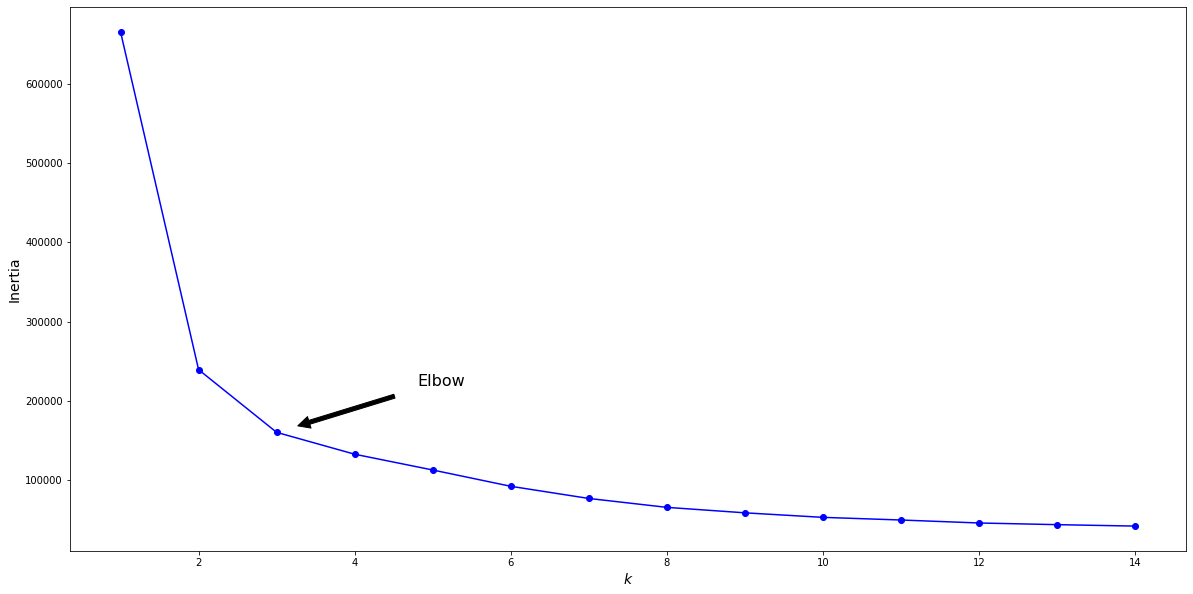

In [202]:
plt.figure(figsize=(20, 10))
plt.plot(range(1, 15), inertias, 'bo-')
plt.xlabel('$k$', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.annotate('Elbow',
             xy=(3, inertias[2]),
             xytext=(0.35, 0.35),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.15)
            )
plt.show()

### **Observation**
We see that there is an elbow at $k=3$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half.

So $k=3$ is a pretty good choice.

### **2.    Silhouette score vs 𝑘**

The silhouette coefficient can vary between -1 and +1:

*   A coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters.
*   A coefficient close to 0 means that it is close to a cluster boundary.
*   A coefficient close to -1 means that the instance may have been assigned to the wrong cluster.




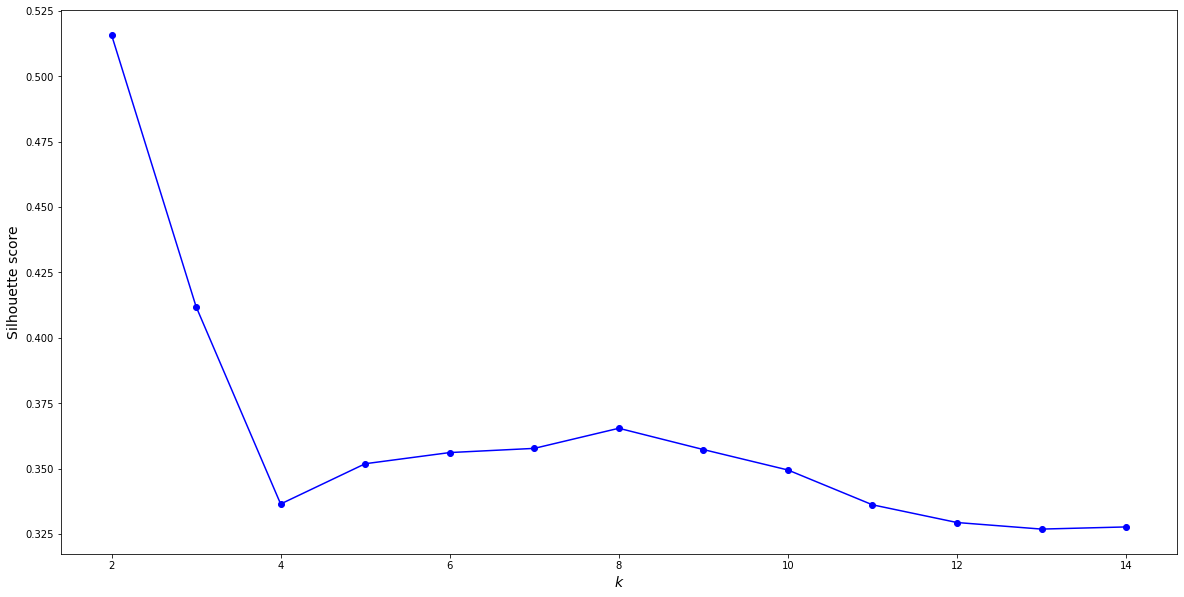

In [214]:
silhouette_scores = [silhouette_score(X, model.labels_) 
                      for model in kmeans_per_k[1:]]    #silhouette scores for models in kmeans_per_k starting at index=1

plt.figure(figsize=(20, 10))
plt.plot(range(2, 15), silhouette_scores, 'bo-')  #setting the range for plot equal to the range used for kmeans.
plt.xlabel('$k$', fontsize=14)
plt.ylabel('Silhouette score', fontsize=14)
# plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()





## **Observation**

This visualization is much better than the previous one: in particular, although it confirms that $k$ = 3 is a good choice since $k$ after that has lower silhouette score, we still can't be sure of optimal $k$ until we look at tge Silhouette Diagram.

## **Silhouette Diagram** 

An even more informative visualization is given when we plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient.

This is called a silhouette diagram.

Each diagram contains one knife shape per cluster. The shape’s height indicates the number of instances the cluster contains, and its width represents the sorted silhouette coefficients of the instances in the cluster (wider is better). The dashed line indicates the mean silhouette coefficient.

### **Note:**
Since we got the best results for the optimal $k$ at $k$ = 3, we will select that optimal $k$ and we saw an increasing trend in silhouette score up until $k$ = 8 so we will select the range of $k$ = 3 to $k$ = 8 to consolidate the best optimal $k$.

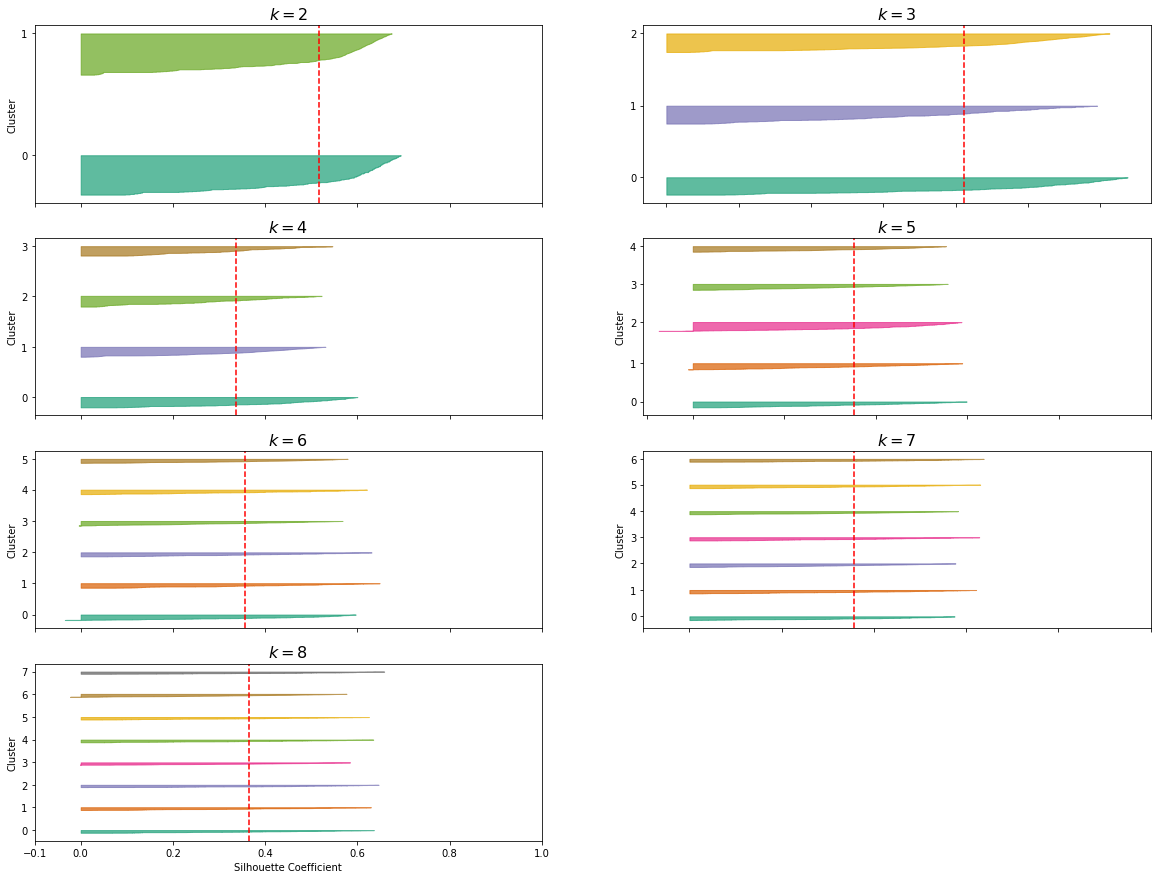

In [217]:
plt.figure(figsize=(20,15))

for k in (2, 3, 4, 5, 6, 7, 8):
  plt.subplot(4, 2, k - 1)

  y_pred = kmeans_per_k[k - 1].labels_ # using k - 1 because its a list and k = 3 is in 3-1 = 2nd position in the list.
  silhouette_coefficients = silhouette_samples(X, y_pred)

  padding = len(X)
  pos = padding
  ticks = []

  for i in range(k):
    coeffs = silhouette_coefficients[y_pred == i]
    coeffs.sort()

    color = mpl.cm.Dark2(i / k)
    plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0 , coeffs,
                      facecolor=color, edgecolor=color, alpha=0.7)
    ticks.append(pos + len(coeffs))
    pos += len(coeffs) + padding

  plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
  plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
  if k in (2, 8):
    plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.ylabel("Cluster")

  if k in (4, 5):
    plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.ylabel("Cluster")
    
  if k in (6, 7):
    plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.ylabel("Cluster")

  if k == 8:
    plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.ylabel("Cluster")
    plt.xlabel("Silhouette Coefficient")
  else:
    plt.tick_params(labelbottom=False)

  plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
  plt.title("$k={}$".format(k), fontsize=16)

plt.show()


## **Observation: Silhouette Diagram**

The vertical dashed lines represent the silhouette score for each number of clusters.

When most of the instances in a cluster have a lower coefficient than this score (i.e., if many of the instances stop short of the dashed line, ending to the left of it), then the cluster is rather bad since this means its instances are much too close to other clusters. We cannot see this anywhere, infact starting at $k$ = 3, all the way to $k$ = 8, the clusters look pretty good: most instances extend upto or beyond the dashed line, to the right and closer to 1.0. 

This  was not what we were expecting. We expected to get good cluster at $k$ = 3 based on its silhouette score, but what we noticed was as $k$ went up, the clusters got smaller and better. So, this actually leads me to believe that our clusters might not be spherical as KMeans expected to be!!!

### **Plotting the clusters for better visual**

### 1. Using T-SNE algorithm for dimensionality reduction